# Brain Tumor Detector

## Get and Load Dataset

To download large files from Google Drive (where the dataset is located), I run the following cell.

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj 

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
To: /content/brain_tumor.zip
100% 156M/156M [00:03<00:00, 43.8MB/s]


Now the dataset has been downloaded, but needs to be unzipped.

In [3]:
!unzip -q brain_tumor.zip

There are now three folders:
- sample_data
- Testing
-Training

In [4]:
ls -l

total 152152
-rw-r--r-- 1 root root 155791278 Mar  9 13:39 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Mar  7 18:14 sample_data/
drwxr-xr-x 6 root root      4096 Mar  9 13:39 Testing/
drwxr-xr-x 6 root root      4096 Mar  9 13:39 Training/


To see folder structures, I run the following cell only on linux systems like colab

In [5]:
!sudo apt-get install tree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (54.3 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 128275 files and directories currently install

In [6]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures

./Training/
├── glioma [1321 entries exceeds filelimit, not opening dir]
├── meningioma [1339 entries exceeds filelimit, not opening dir]
├── notumor [1595 entries exceeds filelimit, not opening dir]
└── pituitary [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures

./Testing/
├── glioma [300 entries exceeds filelimit, not opening dir]
├── meningioma [306 entries exceeds filelimit, not opening dir]
├── notumor [405 entries exceeds filelimit, not opening dir]
└── pituitary [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.11.0


## Utility functions to create dataset generators

I will use the function "tf.keras.preprocessing.image_dataset_from_directory" as suggested in the tutorial here: https://www.tensorflow.org/tutorials/load_data/images

It will return the train and validation datasets ready to be used by a CNN model.


In [9]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds




the "eval_model_on_test" will be used once the model has been trained.

In [10]:
# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128
    )

    test_labels = []
    predictions = []

    for imgs, labels in test_ds.take(100): #tqdm(test_ds.take(100), desc='Predicting on Test Data')
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

The "model_training_and_evaluation" trains the model with training and validation datasets and plots the results.

In [44]:
def model_training_and_evaluation (model, train_ds, val_ds, epochs, class_weights=None, callbacks=None, opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)):
    
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      class_weight = class_weights,
      callbacks=callbacks, 
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    y_true, y_pred_array = eval_model_on_test(model)
    
    y_pred = [np.argmax(prediction, axis = 0) for prediction in y_pred_array]

    y_true_classes = [classes[x] for x in y_true]
    y_pred_classes = [classes[x] for x in y_pred]
    print(f"Baseline Accuracy: {accuracy_score(y_true_classes, y_pred_classes)*100:.2f}%\n")
    print(classification_report(y_true_classes, y_pred_classes))
    
    
    return pd.DataFrame(confusion_matrix(y_true_classes, y_pred_classes), columns=classes, index=classes)

## Using the previously defined function to create the training and validation dataset.

In [12]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


## Configure the dataset for performance

I make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

A naive implementation with no caching or prefetching leads to the following:

![](https://www.tensorflow.org/guide/images/data_performance/naive.svg)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

![](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)



In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Plotting the images and their label

Let's take a look at how the images look like.

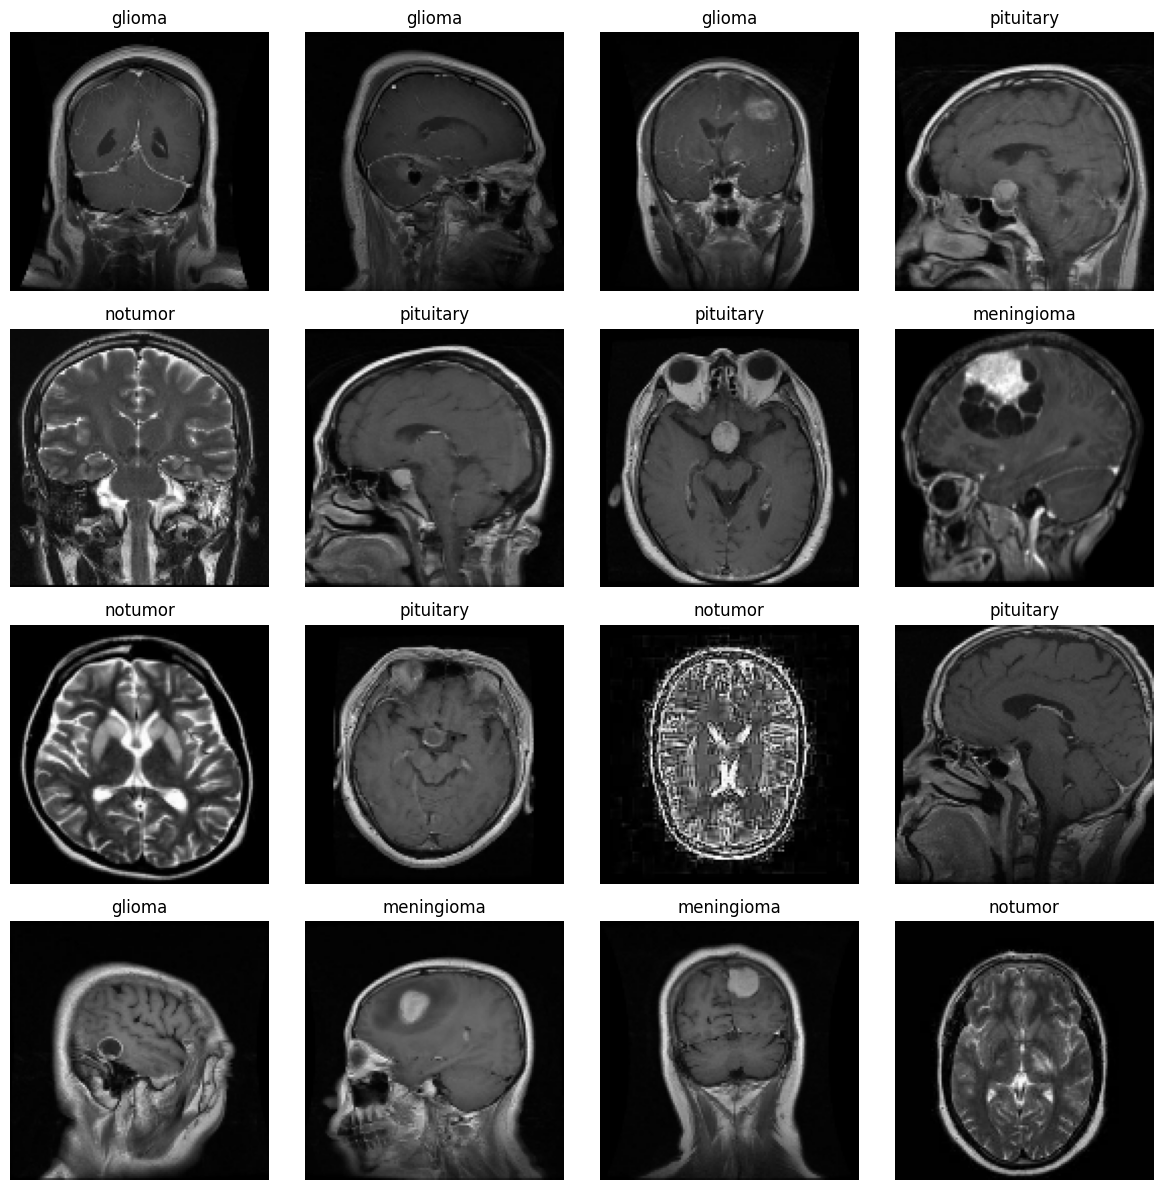

In [14]:
plt.figure(figsize=(12, 12), dpi=100)

for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title((classes[labels[i]]))
        plt.axis("off")
plt.tight_layout()

## Baseline Model

I now create a simple baseline model to see  what the baseline score is. 

In [27]:
# Baseline CNN model with 3 layers

num_classes = len(classes)
img_height, img_width = IMG_DIMS

baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
# Train Baseline Model

epochs=10
history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
143/143 [==============================] - 23s 44ms/step - loss: 0.6814 - accuracy: 0.7223 - val_loss: 0.5168 - val_accuracy: 0.7951
Epoch 2/10
143/143 [==============================] - 7s 51ms/step - loss: 0.3380 - accuracy: 0.8711 - val_loss: 0.2949 - val_accuracy: 0.9028
Epoch 3/10
143/143 [==============================] - 9s 57ms/step - loss: 0.2240 - accuracy: 0.9184 - val_loss: 0.2548 - val_accuracy: 0.9133
Epoch 4/10
143/143 [==============================] - 8s 58ms/step - loss: 0.1357 - accuracy: 0.9551 - val_loss: 0.2510 - val_accuracy: 0.9264
Epoch 5/10
143/143 [==============================] - 8s 56ms/step - loss: 0.0904 - accuracy: 0.9674 - val_loss: 0.2102 - val_accuracy: 0.9326
Epoch 6/10
143/143 [==============================] - 6s 38ms/step - loss: 0.0733 - accuracy: 0.9729 - val_loss: 0.2667 - val_accuracy: 0.9212
Epoch 7/10
143/143 [==============================] - 7s 47ms/step - loss: 0.0548 - accuracy: 0.9816 - val_loss: 0.2688 - val_accuracy: 0.922

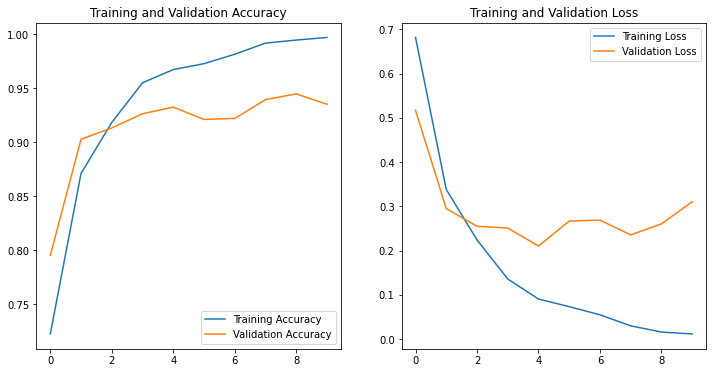

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
baseline_y_true, baseline_y_pred_array = eval_model_on_test(baseline_model)

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 309ms/step


In [ ]:
baseline_y_pred = [np.argmax(prediction, axis = 0) for prediction in baseline_y_pred_array]

Print the classification report and the confusion matrix

In [ ]:
baseline_y_true_classes = [classes[x] for x in baseline_y_true]
baseline_y_pred_classes = [classes[x] for x in baseline_y_pred]
print(f"Baseline Accuracy: {accuracy_score(baseline_y_true_classes, baseline_y_pred_classes)*100:.2f}%\n")
print(classification_report(baseline_y_true_classes, baseline_y_pred_classes))
pd.DataFrame(confusion_matrix(baseline_y_true_classes, baseline_y_pred_classes))

Baseline Accuracy: 94.51%

              precision    recall  f1-score   support

      glioma       0.95      0.90      0.92       300
  meningioma       0.87      0.92      0.90       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.96      0.97       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



,0,1,2,3
0,269,29,1,1
1,9,282,11,4
2,2,2,401,0
3,3,10,0,287


The baseline model is perfoming well, however the validation loss is increasing during the last epochs.

## Baseline with Data Augmentation

Since the baseline model is performing quite well, I test if augmenting the dataset improves the score.

### Random Flip

In [45]:
# Baseline Model with Random Flip

num_classes = len(classes)
img_height, img_width = IMG_DIMS


aug_baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.RandomFlip("horizontal_and_vertical"),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



Epoch 1/10
143/143 [==============================] - 3s 20ms/step - loss: 0.6780 - accuracy: 0.7173 - val_loss: 0.5692 - val_accuracy: 0.7680
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 0.3773 - accuracy: 0.8519 - val_loss: 0.3562 - val_accuracy: 0.8669
Epoch 3/10
143/143 [==============================] - 3s 19ms/step - loss: 0.2363 - accuracy: 0.9158 - val_loss: 0.2641 - val_accuracy: 0.9194
Epoch 4/10
143/143 [==============================] - 3s 18ms/step - loss: 0.1638 - accuracy: 0.9451 - val_loss: 0.2292 - val_accuracy: 0.9299
Epoch 5/10
143/143 [==============================] - 3s 18ms/step - loss: 0.0861 - accuracy: 0.9711 - val_loss: 0.2426 - val_accuracy: 0.9256
Epoch 6/10
143/143 [==============================] - 3s 24ms/step - loss: 0.0804 - accuracy: 0.9726 - val_loss: 0.2898 - val_accuracy: 0.9168
Epoch 7/10
143/143 [==============================] - 3s 18ms/step - loss: 0.0606 - accuracy: 0.9801 - val_loss: 0.2982 - val_accuracy: 0.9072

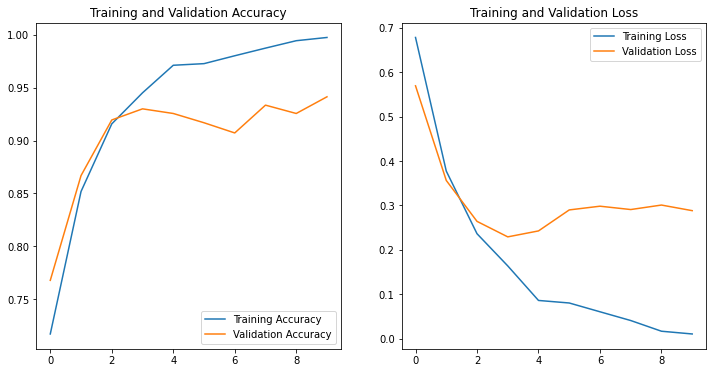

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 78ms/step
Baseline Accuracy: 93.90%

              precision    recall  f1-score   support

      glioma       0.94      0.87      0.91       300
  meningioma       0.86      0.90      0.88       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



,glioma,meningioma,notumor,pituitary
glioma,262,35,2,1
meningioma,13,275,15,3
notumor,2,4,399,0
pituitary,1,4,0,295


In [46]:
epochs = 10
model_training_and_evaluation(aug_baseline_model, train_ds, val_ds, epochs)

The model performs slightly worse by adding **Random flip**

### Adding Random Rotation

Epoch 1/10


143/143 [==============================] - 14s 82ms/step - loss: 0.8735 - accuracy: 0.6435 - val_loss: 0.7720 - val_accuracy: 0.6926
Epoch 2/10
143/143 [==============================] - 10s 66ms/step - loss: 0.5463 - accuracy: 0.7886 - val_loss: 0.7574 - val_accuracy: 0.6926
Epoch 3/10
143/143 [==============================] - 10s 71ms/step - loss: 0.4915 - accuracy: 0.8042 - val_loss: 0.7403 - val_accuracy: 0.7207
Epoch 4/10
143/143 [==============================] - 10s 70ms/step - loss: 0.4285 - accuracy: 0.8344 - val_loss: 0.6634 - val_accuracy: 0.7653
Epoch 5/10
143/143 [==============================] - 10s 70ms/step - loss: 0.3955 - accuracy: 0.8519 - val_loss: 0.5101 - val_accuracy: 0.8266
Epoch 6/10
143/143 [==============================] - 10s 71ms/step - loss: 0.3679 - accuracy: 0.8584 - val_loss: 0.5000 - val_accuracy: 0.8100
Epoch 7/10
143/143 [==============================] - 9s 64ms/step - loss: 0.3323 - accuracy: 0.8748 - val_loss: 0.7791 - val_accuracy: 0.6996
Epoc

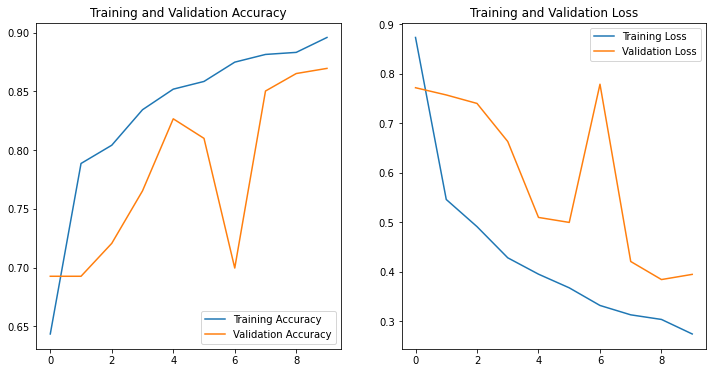

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 77ms/step
Baseline Accuracy: 82.07%

              precision    recall  f1-score   support

      glioma       0.91      0.68      0.78       300
  meningioma       0.72      0.65      0.68       306
     notumor       0.77      0.99      0.87       405
   pituitary       0.94      0.91      0.92       300

    accuracy                           0.82      1311
   macro avg       0.83      0.81      0.81      1311
weighted avg       0.83      0.82      0.82      1311



,glioma,meningioma,notumor,pituitary
glioma,205,67,21,7
meningioma,12,198,85,11
notumor,2,2,401,0
pituitary,6,8,14,272


In [47]:
# Baseline Model with Random Rotation

aug_baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.RandomRotation(0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_training_and_evaluation(aug_baseline_model, train_ds, val_ds, epochs)


The model performs worse with **Random Rotation**

### Adding Random Brightness

Epoch 1/10


143/143 [==============================] - 11s 67ms/step - loss: 3.4642 - accuracy: 0.2569 - val_loss: 1.3806 - val_accuracy: 0.3047
Epoch 2/10
143/143 [==============================] - 9s 65ms/step - loss: 1.3853 - accuracy: 0.2718 - val_loss: 1.3798 - val_accuracy: 0.3047
Epoch 3/10
143/143 [==============================] - 9s 61ms/step - loss: 1.3850 - accuracy: 0.2729 - val_loss: 1.3796 - val_accuracy: 0.3047
Epoch 4/10
143/143 [==============================] - 12s 82ms/step - loss: 1.3849 - accuracy: 0.2729 - val_loss: 1.3794 - val_accuracy: 0.3047
Epoch 5/10
143/143 [==============================] - 11s 73ms/step - loss: 1.3849 - accuracy: 0.2729 - val_loss: 1.3790 - val_accuracy: 0.3047
Epoch 6/10
143/143 [==============================] - 10s 69ms/step - loss: 1.3848 - accuracy: 0.2729 - val_loss: 1.3792 - val_accuracy: 0.3047
Epoch 7/10
143/143 [==============================] - 9s 65ms/step - loss: 1.3848 - accuracy: 0.2729 - val_loss: 1.3795 - val_accuracy: 0.3047
Epoch 

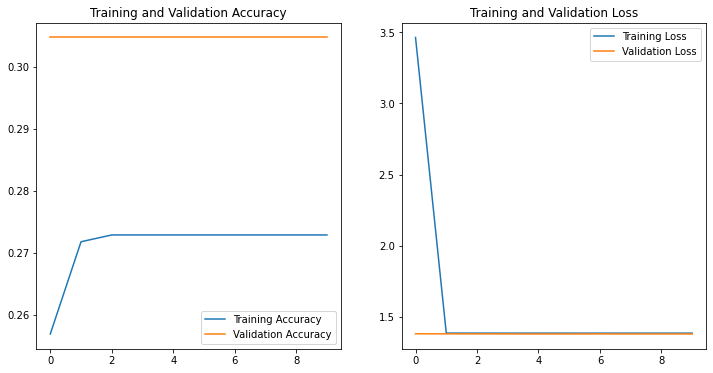

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 92ms/step
Baseline Accuracy: 30.89%

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,glioma,meningioma,notumor,pituitary
glioma,0,0,300,0
meningioma,0,0,306,0
notumor,0,0,405,0
pituitary,0,0,300,0


In [48]:
# Baseline Model with Data Augmentation

aug_baseline_model_2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  
  layers.RandomBrightness(factor=0.2), #value_range=(0, 255), seed=42)
  layers.Conv2D(16, 3, padding='same', activation='relu'), # additional to a 3x3 patch size, use stride!
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model_training_and_evaluation(aug_baseline_model_2, train_ds, val_ds, epochs)

The model also performs worse with **Random Brightness**

## Reducing Overfitting

Data augmentation didn't improve the score. I now try reducing overfitting

### Dropout

Epoch 1/10
143/143 [==============================] - 3s 17ms/step - loss: 0.7685 - accuracy: 0.6989 - val_loss: 0.4627 - val_accuracy: 0.8459
Epoch 2/10
143/143 [==============================] - 2s 14ms/step - loss: 0.3783 - accuracy: 0.8545 - val_loss: 0.3247 - val_accuracy: 0.8897
Epoch 3/10
143/143 [==============================] - 2s 14ms/step - loss: 0.2529 - accuracy: 0.9072 - val_loss: 0.2620 - val_accuracy: 0.9081
Epoch 4/10
143/143 [==============================] - 2s 14ms/step - loss: 0.1868 - accuracy: 0.9309 - val_loss: 0.2582 - val_accuracy: 0.9098
Epoch 5/10
143/143 [==============================] - 2s 13ms/step - loss: 0.1274 - accuracy: 0.9567 - val_loss: 0.2463 - val_accuracy: 0.9116
Epoch 6/10
143/143 [==============================] - 2s 14ms/step - loss: 0.0946 - accuracy: 0.9689 - val_loss: 0.2318 - val_accuracy: 0.9282
Epoch 7/10
143/143 [==============================] - 2s 16ms/step - loss: 0.0733 - accuracy: 0.9746 - val_loss: 0.2763 - val_accuracy: 0.9081

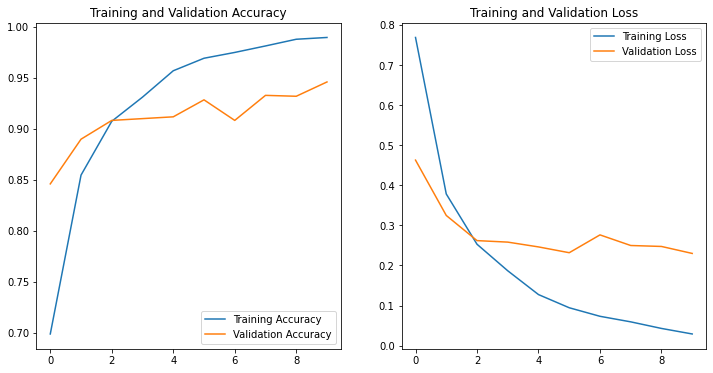

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 75ms/step
Baseline Accuracy: 94.58%

              precision    recall  f1-score   support

      glioma       0.95      0.90      0.93       300
  meningioma       0.90      0.89      0.89       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



,glioma,meningioma,notumor,pituitary
glioma,270,25,2,3
meningioma,11,272,14,9
notumor,2,2,401,0
pituitary,0,3,0,297


In [49]:
# Baseline CNN model with dropout


do_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(.3),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model_training_and_evaluation(do_model, train_ds, val_ds, epochs)


With a **dropout layer**, the model performance is stable. However the validation accuracy line is less smooth. 

### Regularization

Epoch 1/20
143/143 [==============================] - 2s 13ms/step - loss: 2.3893 - accuracy: 0.6409 - val_loss: 0.8755 - val_accuracy: 0.7636
Epoch 2/20
143/143 [==============================] - 2s 11ms/step - loss: 0.7878 - accuracy: 0.7908 - val_loss: 0.6987 - val_accuracy: 0.8240
Epoch 3/20
143/143 [==============================] - 2s 11ms/step - loss: 0.6367 - accuracy: 0.8278 - val_loss: 0.6846 - val_accuracy: 0.8144
Epoch 4/20
143/143 [==============================] - 2s 12ms/step - loss: 0.5560 - accuracy: 0.8481 - val_loss: 0.5471 - val_accuracy: 0.8590
Epoch 5/20
143/143 [==============================] - 2s 11ms/step - loss: 0.4735 - accuracy: 0.8746 - val_loss: 0.5179 - val_accuracy: 0.8678
Epoch 6/20
143/143 [==============================] - 2s 11ms/step - loss: 0.4252 - accuracy: 0.8932 - val_loss: 0.5273 - val_accuracy: 0.8634
Epoch 7/20
143/143 [==============================] - 2s 11ms/step - loss: 0.3808 - accuracy: 0.9074 - val_loss: 0.5048 - val_accuracy: 0.8792

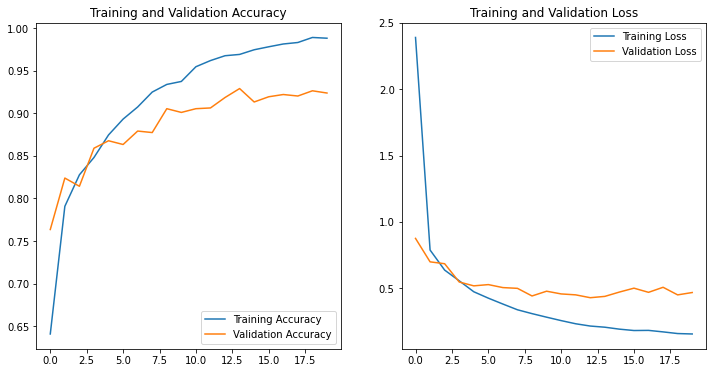

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 80ms/step
Baseline Accuracy: 93.75%

              precision    recall  f1-score   support

      glioma       0.95      0.87      0.91       300
  meningioma       0.88      0.88      0.88       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



,glioma,meningioma,notumor,pituitary
glioma,262,32,1,5
meningioma,13,269,16,8
notumor,1,5,399,0
pituitary,0,1,0,299


In [50]:
# Baseline CNN model with regularizers and dropout
from tensorflow.keras import regularizers
num_classes = len(classes)
img_height, img_width = IMG_DIMS
epochs=20


reg_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer='l1_l2'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer='l1_l2'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer='l1_l2'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model_training_and_evaluation(reg_model, train_ds, val_ds, epochs)


Unfortunately it doesn't seem to avoid overfitting.

### Class Weights

Since the model makes most of the mistakes with the glioma and miningioma class, I try by increasing the weigths for these two classes.

In [51]:
class_weight_dict = { 0 : 1.5, 1:1.5, 2:1, 3:1}
class_weight_dict

{0: 1.5, 1: 1.5, 2: 1, 3: 1}

Epoch 1/20
143/143 [==============================] - 4s 21ms/step - loss: 0.9186 - accuracy: 0.7131 - val_loss: 0.4684 - val_accuracy: 0.8468
Epoch 2/20
143/143 [==============================] - 2s 14ms/step - loss: 0.4754 - accuracy: 0.8646 - val_loss: 0.3660 - val_accuracy: 0.8722
Epoch 3/20
143/143 [==============================] - 2s 14ms/step - loss: 0.3441 - accuracy: 0.9044 - val_loss: 0.2672 - val_accuracy: 0.9142
Epoch 4/20
143/143 [==============================] - 2s 14ms/step - loss: 0.2171 - accuracy: 0.9433 - val_loss: 0.2283 - val_accuracy: 0.9247
Epoch 5/20
143/143 [==============================] - 2s 14ms/step - loss: 0.1586 - accuracy: 0.9611 - val_loss: 0.2173 - val_accuracy: 0.9308
Epoch 6/20
143/143 [==============================] - 2s 14ms/step - loss: 0.1025 - accuracy: 0.9777 - val_loss: 0.2379 - val_accuracy: 0.9238
Epoch 7/20
143/143 [==============================] - 2s 14ms/step - loss: 0.0841 - accuracy: 0.9816 - val_loss: 0.2734 - val_accuracy: 0.9212

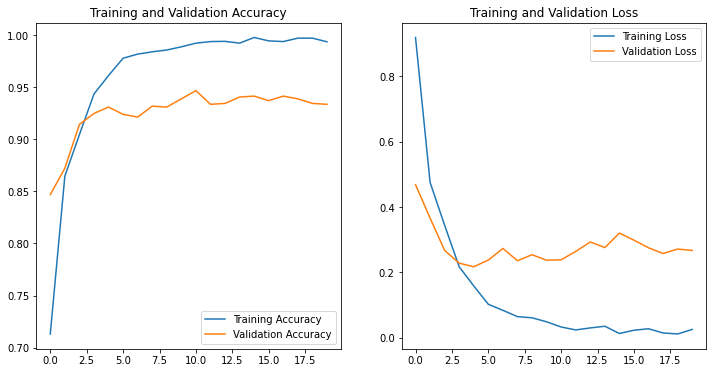

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 79ms/step
Baseline Accuracy: 93.52%

              precision    recall  f1-score   support

      glioma       0.95      0.92      0.94       300
  meningioma       0.92      0.82      0.87       306
     notumor       0.92      0.99      0.95       405
   pituitary       0.96      0.99      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.93      0.94      0.93      1311



,glioma,meningioma,notumor,pituitary
glioma,276,17,3,4
meningioma,14,251,32,9
notumor,0,4,401,0
pituitary,0,2,0,298


In [53]:
# Baseline CNN model with dropout and class weights

cw_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(.3),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model_training_and_evaluation(cw_model, train_ds, val_ds, epochs, class_weights = class_weight_dict)


The score also didn't improve.

### Dynamic Learning Rate and Early Stopping

In [54]:
def lr_function(epoch):
    start_lr = 1e-6; min_lr = 1e-6; max_lr = 1e-4
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .8
    
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, 
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs 
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) * 
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, 
              rampup_epochs, sustain_epochs, exp_decay)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/20
143/143 [==============================] - 3s 14ms/step - loss: 1.6170 - accuracy: 0.3958 - val_loss: 1.2316 - val_accuracy: 0.4107 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 2.08e-05.
Epoch 2/20
143/143 [==============================] - 2s 12ms/step - loss: 1.0774 - accuracy: 0.6615 - val_loss: 0.6957 - val_accuracy: 0.7531 - lr: 2.0800e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.06e-05.
Epoch 3/20
143/143 [==============================] - 2s 12ms/step - loss: 0.7409 - accuracy: 0.7836 - val_loss: 0.4887 - val_accuracy: 0.8310 - lr: 4.0600e-05

Epoch 4: LearningRateScheduler setting learning rate to 6.04e-05.
Epoch 4/20
143/143 [==============================] - 2s 12ms/step - loss: 0.5900 - accuracy: 0.8409 - val_loss: 0.4600 - val_accuracy: 0.8459 - lr: 6.0400e-05

Epoch 5: LearningRateScheduler setting learning rate to 8.02e-05.
Epoch 5/20
143/143 [========

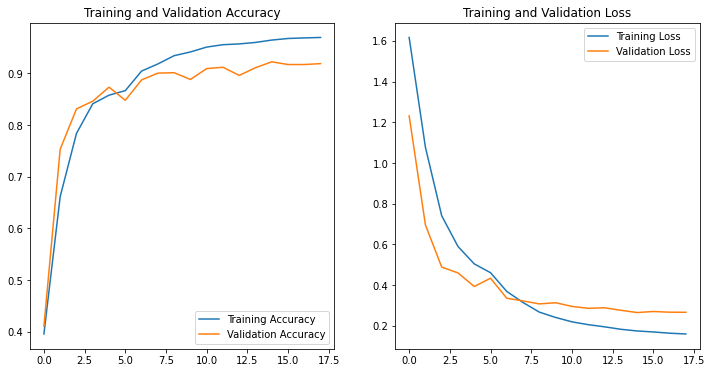

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 74ms/step
Baseline Accuracy: 90.77%

              precision    recall  f1-score   support

      glioma       0.90      0.87      0.88       300
  meningioma       0.87      0.78      0.82       306
     notumor       0.92      0.98      0.95       405
   pituitary       0.94      0.99      0.96       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



,glioma,meningioma,notumor,pituitary
glioma,261,32,2,5
meningioma,24,238,32,12
notumor,4,3,395,3
pituitary,2,1,1,296


In [55]:
# Baseline CNN model with learning rate and early stopping

num_classes = len(classes)
img_height, img_width = IMG_DIMS

baseline_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_function(epoch), verbose=True)
    ]

model_training_and_evaluation(baseline_model, train_ds, val_ds, epochs, class_weights = class_weight_dict, callbacks=callbacks)


Also a dynamic learning rate doesn't produce better results.

##  Transfer learning with ResNet50



## ResNet50 Model (bottom not trainable)

In the following cells, I will use the convolutional part of the ResNet50 model for transfer learning.

In [56]:
model_name = 'resnet50_v01'


# load a new instance of the model withut the top
resnet50_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_DIMS+(3,),
                                                         include_top=False,
                                                         weights='imagenet',
                                                         )
#I block the convolutional part of the network
resnet50_model.trainable = False

94765736/94765736 [==============================] - 7s 0us/step


In [57]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [58]:
num_classes = 4

tl_resnet = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_DIMS+(3,)),
  resnet50_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

tl_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [64]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)


In [65]:
history = tl_resnet.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks = [early_stopping_cb],
                    ) 

Epoch 1/20
143/143 [==============================] - 13s 65ms/step - loss: 1.1144 - accuracy: 0.5072 - val_loss: 0.8970 - val_accuracy: 0.6392
Epoch 2/20
143/143 [==============================] - 6s 45ms/step - loss: 0.8810 - accuracy: 0.6449 - val_loss: 0.8291 - val_accuracy: 0.6480
Epoch 3/20
143/143 [==============================] - 6s 45ms/step - loss: 0.7660 - accuracy: 0.6937 - val_loss: 0.7229 - val_accuracy: 0.7145
Epoch 4/20
143/143 [==============================] - 6s 45ms/step - loss: 0.6987 - accuracy: 0.7291 - val_loss: 0.6818 - val_accuracy: 0.7294
Epoch 5/20
143/143 [==============================] - 7s 45ms/step - loss: 0.6672 - accuracy: 0.7350 - val_loss: 0.6181 - val_accuracy: 0.7583
Epoch 6/20
143/143 [==============================] - 7s 46ms/step - loss: 0.6197 - accuracy: 0.7516 - val_loss: 0.6044 - val_accuracy: 0.7539
Epoch 7/20
143/143 [==============================] - 7s 46ms/step - loss: 0.5989 - accuracy: 0.7615 - val_loss: 0.5762 - val_accuracy: 0.779

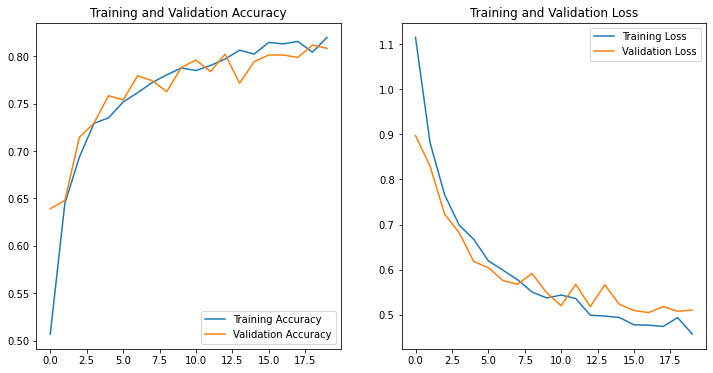

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 1s 1s/step
Baseline Accuracy: 76.66%

              precision    recall  f1-score   support

      glioma       0.75      0.66      0.70       300
  meningioma       0.63      0.61      0.62       306
     notumor       0.88      0.85      0.86       405
   pituitary       0.77      0.92      0.84       300

    accuracy                           0.77      1311
   macro avg       0.76      0.76      0.76      1311
weighted avg       0.77      0.77      0.76      1311



In [68]:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    y_true, y_pred_array = eval_model_on_test(tl_resnet)
    
    y_pred = [np.argmax(prediction, axis = 0) for prediction in y_pred_array]

    y_true_classes = [classes[x] for x in y_true]
    y_pred_classes = [classes[x] for x in y_pred]
    print(f"Baseline Accuracy: {accuracy_score(y_true_classes, y_pred_classes)*100:.2f}%\n")
    print(classification_report(y_true_classes, y_pred_classes))

The score is low, but maybe can be improved by training the convolutional part of the network. It was now set to "not trainable".

## ResNet50 Model (trainable from layer 100)

Let's now train from the 100th layer of the network.

In [70]:
resnet50_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet50_model.layers[:fine_tune_at]:
  layer.trainable =  False


num_classes = 4

tl_resnet = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_DIMS+(3,)),
  resnet50_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256),
  layers.Dropout(0.2),
  layers.Dense(num_classes, activation='softmax')
])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True),
    ]

In [71]:
tl_resnet.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_46 (Dense)            (None, 256)               524544    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 4)                 1028      
                                                     

The total trainable parameters is now 19M.

Epoch 1/20
143/143 [==============================] - 29s 93ms/step - loss: 1.7030 - accuracy: 0.3967 - val_loss: 1.4235 - val_accuracy: 0.3161
Epoch 2/20
143/143 [==============================] - 12s 82ms/step - loss: 1.0180 - accuracy: 0.6722 - val_loss: 1.1459 - val_accuracy: 0.4676
Epoch 3/20
143/143 [==============================] - 11s 79ms/step - loss: 0.8160 - accuracy: 0.7589 - val_loss: 0.6658 - val_accuracy: 0.7539
Epoch 4/20
143/143 [==============================] - 11s 79ms/step - loss: 0.6793 - accuracy: 0.8103 - val_loss: 0.5592 - val_accuracy: 0.7960
Epoch 5/20
143/143 [==============================] - 11s 79ms/step - loss: 0.5774 - accuracy: 0.8442 - val_loss: 0.5159 - val_accuracy: 0.8091
Epoch 6/20
143/143 [==============================] - 11s 78ms/step - loss: 0.4904 - accuracy: 0.8796 - val_loss: 0.4819 - val_accuracy: 0.8196
Epoch 7/20
143/143 [==============================] - 11s 78ms/step - loss: 0.4401 - accuracy: 0.8965 - val_loss: 0.4624 - val_accuracy:

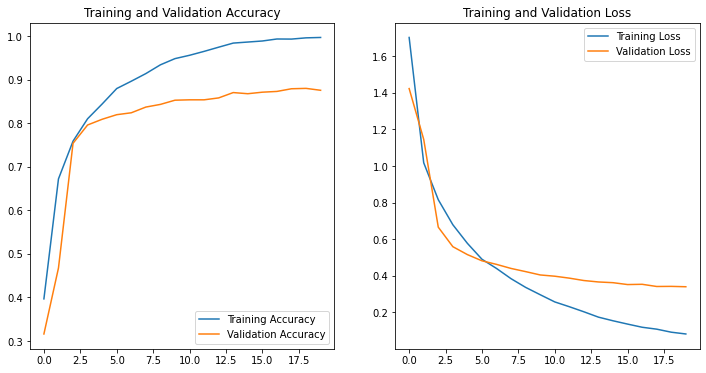

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 1s 871ms/step
Baseline Accuracy: 88.10%

              precision    recall  f1-score   support

      glioma       0.87      0.80      0.83       300
  meningioma       0.81      0.74      0.77       306
     notumor       0.91      0.98      0.94       405
   pituitary       0.92      0.97      0.95       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



,glioma,meningioma,notumor,pituitary
glioma,240,43,7,10
meningioma,34,225,32,15
notumor,2,5,398,0
pituitary,1,6,1,292


In [72]:
# the default learning rate is 1e-3 but since we want to avoid abrupt changes to the weights of the network, I decrease the learning rate to 1e-6 
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6)

model_training_and_evaluation(tl_resnet, train_ds, val_ds, epochs, class_weights = class_weight_dict, callbacks=callbacks, opt = optimizer)


The score improved but is still not better than the baseline model. I now try with a completely trainable model.

## ResNet50 Model (training all layers)

Epoch 1/20
143/143 [==============================] - 52s 142ms/step - loss: 2.1693 - accuracy: 0.3389 - val_loss: 1.8284 - val_accuracy: 0.1716
Epoch 2/20
143/143 [==============================] - 19s 136ms/step - loss: 1.4474 - accuracy: 0.5326 - val_loss: 1.6900 - val_accuracy: 0.2172
Epoch 3/20
143/143 [==============================] - 18s 126ms/step - loss: 1.0720 - accuracy: 0.6621 - val_loss: 1.6198 - val_accuracy: 0.1979
Epoch 4/20
143/143 [==============================] - 18s 126ms/step - loss: 0.8422 - accuracy: 0.7403 - val_loss: 1.5240 - val_accuracy: 0.2855
Epoch 5/20
143/143 [==============================] - 18s 127ms/step - loss: 0.6767 - accuracy: 0.8013 - val_loss: 1.3988 - val_accuracy: 0.3459
Epoch 6/20
143/143 [==============================] - 18s 128ms/step - loss: 0.5731 - accuracy: 0.8425 - val_loss: 1.1726 - val_accuracy: 0.4825
Epoch 7/20
143/143 [==============================] - 18s 127ms/step - loss: 0.4933 - accuracy: 0.8626 - val_loss: 0.9155 - val_ac

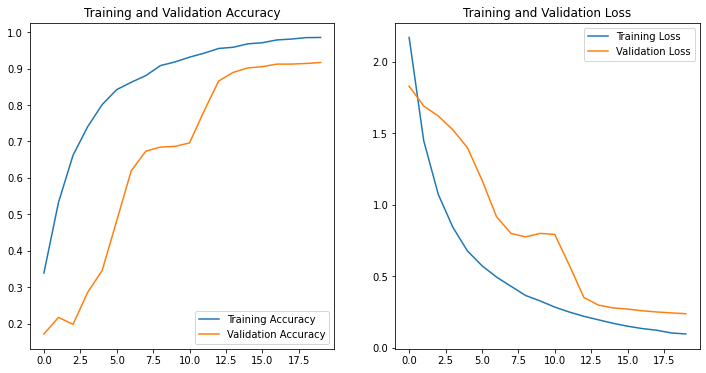

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 1s 822ms/step
Baseline Accuracy: 90.47%

              precision    recall  f1-score   support

      glioma       0.91      0.83      0.87       300
  meningioma       0.82      0.85      0.83       306
     notumor       0.95      0.98      0.97       405
   pituitary       0.92      0.93      0.93       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



,glioma,meningioma,notumor,pituitary
glioma,250,44,0,6
meningioma,13,261,17,15
notumor,5,2,396,2
pituitary,6,13,2,279


In [73]:
resnet50_model.trainable = True

num_classes = 4

tl_resnet = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_DIMS+(3,)),
  resnet50_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation='softmax')
])


callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True),
    ]

# the default learning rate is 1e-3 but since we want to avoid abrupt changes to the weights of the network, I decrease the learning rate 
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6)

model_training_and_evaluation(tl_resnet, train_ds, val_ds, epochs, class_weights = class_weight_dict, callbacks=callbacks, opt = optimizer)

The score improved but is still not higher than the baseline model.

### Dinamic learing rate 

To decrease the overfitting, I try with a dinamic learning rate. 

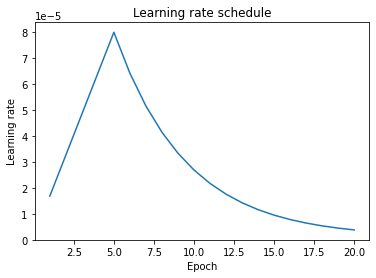

In [74]:
def lr_function(epoch):
    start_lr = 1e-6; min_lr = 1e-6; max_lr = 8e-5
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .8
    
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, 
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs 
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) * 
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, 
              rampup_epochs, sustain_epochs, exp_decay)


x = range(1, 21)
y = [lr_function(epoch) for epoch in x]
plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate schedule')
plt.show()


The learning rate follows the shape above: gradually increasing up to 8e-5 and then decreasing again.


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/40
143/143 [==============================] - 55s 134ms/step - loss: 1.8547 - accuracy: 0.4024 - val_loss: 0.7854 - val_accuracy: 0.7154 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.6800000000000002e-05.
Epoch 2/40
143/143 [==============================] - 18s 128ms/step - loss: 0.1458 - accuracy: 0.9534 - val_loss: 0.1132 - val_accuracy: 0.9676 - lr: 1.6800e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.26e-05.
Epoch 3/40
143/143 [==============================] - 18s 129ms/step - loss: 0.0191 - accuracy: 0.9967 - val_loss: 0.1045 - val_accuracy: 0.9702 - lr: 3.2600e-05

Epoch 4: LearningRateScheduler setting learning rate to 4.84e-05.
Epoch 4/40
143/143 [==============================] - 18s 127ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.1109 - val_accuracy: 0.9746 - lr: 4.8400e-05

Epoch 5: LearningRateScheduler setting learning rate to 6.42e-05.
Epoch 

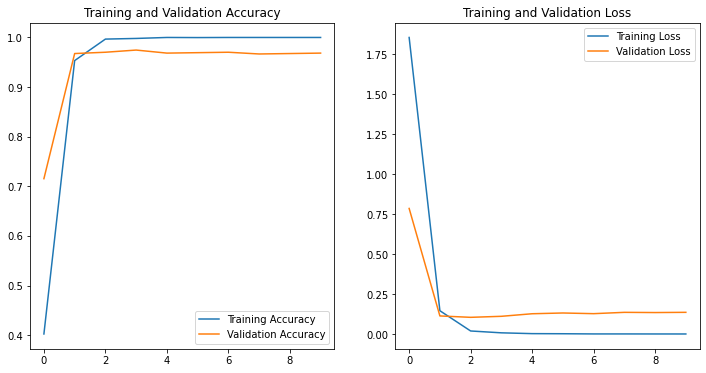

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 2s 2s/step
Baseline Accuracy: 96.57%

              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.92      0.94      0.93       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



,glioma,meningioma,notumor,pituitary
glioma,280,19,0,1
meningioma,2,289,9,6
notumor,0,3,402,0
pituitary,1,4,0,295


In [78]:
num_classes = 4
epochs = 40

tl_resnet = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_DIMS+(3,)),
  resnet50_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(256),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])


    
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_function(epoch), verbose=True)
    ]

# the default learning rate is 1e-3 but since we want to avoid abrupt changes to the weights of the network, I decrease the learning rate 
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6)

model_training_and_evaluation(tl_resnet, train_ds, val_ds, epochs, callbacks=callbacks, opt=optimizer) #class_weights = class_weight_dict

## SUMMARY

- Baseline CNN with 3 convolution layers shows pretty good results for a quick deployment (91%-95%).

- Data augmentation doesn't work well with MRI images, much lower results than without.

- Transfer learning: RESNet50 doesn't show a quick improvement over the baseline model, but can reach a f1 score over 97% with dynamic learning rate and early stopping.
  - No false negatives for glioma or pituitary tumors. Only 3 meningioma MRI images are classified as not tumoral.
  - Meningioma is the most difficult to optimize for --> it is also the most difficult to diagnose for oncologist


- Further steps: 
  - try other models like VGG and Efficient Net
  - include visualizations for AI explainability (GradCAM)